* We will explore data about,
    -  energy supply and renewable electricity production from the United Nations for the year 2013, `Energy Indicators.xls`
    - Countries' GDP from 1960 to 2018 from World Bank `world_gdp.csv`
    -  Sciamgo Journal and Country Rank data for Energy Engineering and Power Technology, which ranks countries based on their journal contributions in the aforementioned area. `scimagojr.xlsx`

### Load and Explore the data

In [44]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML

* In `Energy Indicators.xls` we do not want header rows and footer, let's identify which rows we want to discard.

In [45]:
xl = pd.ExcelFile('data/Energy Indicators.xls')
nrows = xl.book.sheet_by_index(0).nrows
ncols = xl.book.sheet_by_index(0).ncols

In [46]:
nrows

283

In [47]:
ncols

6

* After visualize file in Microsoft Excel, I want to discard first 17 rows. I am interested in rows up to 245.
* Also, NaN is indicated as '...', I want to convert it in NaN.
* First 2 columns is junk, we will discard that too.

In [51]:
energy = pd.read_excel('data/Energy Indicators.xls', skiprows=17, skipfooter=nrows-245, usecols=list(range(2, ncols)), na_values='...')
energy.columns = ['Country', 'Energy Supply', 'Energy Supply per Capita', '% Renewable']

In [52]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 4 columns):
Country                     227 non-null object
Energy Supply               222 non-null float64
Energy Supply per Capita    222 non-null float64
% Renewable                 227 non-null float64
dtypes: float64(3), object(1)
memory usage: 7.2+ KB


In [54]:
display(HTML(energy.to_html()))

,Country,Energy Supply,Energy Supply per Capita,% Renewable
0,Afghanistan,321.0,10.0,78.669280
1,Albania,102.0,35.0,100.000000
2,Algeria,1959.0,51.0,0.551010
3,American Samoa,NaN,NaN,0.641026
4,Andorra,9.0,121.0,88.695650
5,Angola,642.0,27.0,70.909090
6,Anguilla,2.0,136.0,0.000000
7,Antigua and Barbuda,8.0,84.0,0.000000
8,Argentina,3378.0,79.0,24.064520
9,Armenia,143.0,48.0,28.236060


* Hmm, some country name is weird and too long,
    - Number at the end of name, Ex. `Switzerland17`
    - Too long country name Ex. `United Kingdom of Great Britain and Northern I...`
    - Bracket at the end of name Ex. Venezuela (Bolivarian Republic of)
* Let's clean that up.

In [55]:
energy.Country.replace({"Republic of Korea": "South Korea", "United States of America": "United States",
                        "United Kingdom of Great Britain and Northern Ireland": "United Kingdom",
                        "China, Hong Kong Special Administrative Region": "Hong Kong"}, regex=True, inplace=True)
energy.Country.replace('[0-9]', '', regex=True, inplace=True)
energy.Country.replace(r"\(.*\)","", inplace=True, regex= True)
energy.Country = energy.Country.str.strip()

In [56]:
energy['Energy Supply'] *= 1000000 # convert to gigajoules

-------------------------

In [57]:
GDP = pd.read_csv('data/world_gdp.csv',skiprows=4)
GDP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 64 columns):
Country Name      264 non-null object
Country Code      264 non-null object
Indicator Name    264 non-null object
Indicator Code    264 non-null object
1960              134 non-null float64
1961              134 non-null float64
1962              136 non-null float64
1963              136 non-null float64
1964              136 non-null float64
1965              146 non-null float64
1966              147 non-null float64
1967              150 non-null float64
1968              154 non-null float64
1969              154 non-null float64
1970              163 non-null float64
1971              164 non-null float64
1972              164 non-null float64
1973              164 non-null float64
1974              165 non-null float64
1975              169 non-null float64
1976              170 non-null float64
1977              174 non-null float64
1978              173 non-null float64
19

In [58]:
display(HTML(GDP.to_html()))

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,Unnamed: 63
0,Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.054634e+08,4.876025e+08,5.964236e+08,6.953044e+08,7.648871e+08,8.721387e+08,9.584632e+08,1.082980e+09,1.245688e+09,1.320475e+09,1.379961e+09,1.531944e+09,1.665101e+09,1.722799e+09,1.873453e+09,1.920112e+09,1.941341e+09,2.021229e+09,2.228492e+09,2.330726e+09,2.424581e+09,2.615084e+09,2.745251e+09,2.498883e+09,2.390503e+09,2.549721e+09,2.534637e+09,2.581564e+09,2.649721e+09,2.691620e+09,2.646927e+09,2.700559e+09,NaN,NaN
1,Afghanistan,AFG,GDP (current US$),NY.GDP.MKTP.CD,5.377778e+08,5.488889e+08,5.466667e+08,7.511112e+08,8.000000e+08,1.006667e+09,1.400000e+09,1.673333e+09,1.373333e+09,1.408889e+09,1.748887e+09,1.831109e+09,1.595555e+09,1.733333e+09,2.155555e+09,2.366667e+09,2.555556e+09,2.953333e+09,3.300000e+09,3.697940e+09,3.641723e+09,3.478788e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.055180e+09,4.515559e+09,5.226779e+09,6.209138e+09,6.971286e+09,9.747880e+09,1.010923e+10,1.243909e+10,1.585657e+10,1.780429e+10,1.990732e+10,2.056107e+10,2.048489e+10,1.990711e+10,1.904636e+10,1.954398e+10,NaN,NaN
2,Angola,AGO,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.930503e+09,5.550483e+09,5.550483e+09,5.784342e+09,6.131475e+09,7.553560e+09,7.072063e+09,8.083872e+09,8.769251e+09,1.020110e+10,1.122876e+10,1.060378e+10,8.307811e+09,5.768720e+09,4.438321e+09,5.538749e+09,7.526447e+09,7.648377e+09,6.506230e+09,6.152923e+09,9.129595e+09,8.936064e+09,1.528559e+10,1.781271e+10,2.355205e+10,3.697092e+10,5.238101e+10,6.526645e+10,8.853861e+10,7.030716e+10,8.379950e+10,1.117897e+11,1.280529e+11,1.367099e+11,1.457122e+11,1.161936e+11,1.011239e+11,1.221238e+11,NaN,NaN
3,Albania,ALB,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.857338e+09,1.897050e+09,2.097326e+09,2.080796e+09,2.051236e+09,2.253090e+09,2.028554e+09,1.099559e+09,6.521750e+08,1.185315e+09,1.880952e+09,2.392765e+09,3.199641e+09,2.258514e+09,2.545965e+09,3.212122e+09,3.480355e+09,3.922101e+09,4.348068e+09,5.611496e+09,7.184686e+09,8.052074e+09,8.896073e+09,1.067732e+10,1.288135e+10,1.204421e+10,1.192696e+10,1.289087e+10,1.231978e+10,1.277628e+10,1.322825e+10,1.138693e+10,1.188368e+10,1.303854e+10,NaN,NaN
4,Andorra,AND,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.861921e+07,8.940982e+07,1.134082e+08,1.508201e+08,1.865587e+08,2.201272e+08,2.272810e+08,2.540202e+08,3.080089e+08,4.115783e+08,4.464161e+08,3.889587e+08,3.758960e+08,3.278618e+08,3.300707e+08,3.467380e+08,4.820006e+08,6.113164e+08,7.214259e+08,7.954493e+08,1.029048e+09,1.106929e+09,1.210014e+09,1.007026e+09,1.017549e+09,1.178739e+09,1.223945e+09,1.180597e+09,1.211932e+09,1.239876e+09,1.434430e+09,1.496913e+09,1.733117e+09,2.398646e+09,2.935659e+09,3.255789e+09,3.543257e+09,4.016972e+09,4.007353e+09,3.660531e+09,3.355695e+09,3.442063e+09,3.164615e+09,3.281585e+09,3.350736e+09,2.811489e+09,2.877312e+09,3.012914e+09,NaN,NaN
5,Arab World,ARB,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.560218e+10,2.813243e+10,3.170585e+10,3.673303e+10,4.379291e+10,5.544830e+10,1.053416e+11,1.165162e+11,1.448413e+11,1.671563e+11,1.835638e+11,2.485956e+11,3.382488e+11,3.476561e+11,3.260204e+11,3.062618e+11,3.106323e+11,3.074073e+11,2.933674e+11,3.127530e+11,3.075709e+11,3.225231e+11,4.469017e+11,4.406494e+11,4.716716e+11,4.771340e+11,4.876617e+11,5.239290e+11,5.783988e+11,6.134324e+11,5.916816e+11,6.440

* There are few country name which is not matching with `energy` dataframe let's clean that up.

In [59]:
GDP['Country Name'].replace({"Korea, Rep.": "South Korea", "Iran, Islamic Rep.": "Iran",
                            "Hong Kong SAR, China": "Hong Kong"}, inplace=True, regex=True)

In [60]:
GDP.rename(columns={'Country Name':'Country'}, inplace=True)

-------------

In [61]:
ScimEn = pd.read_excel('data/scimagojr.xlsx')

In [62]:
ScimEn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193 entries, 0 to 192
Data columns (total 8 columns):
Rank                      193 non-null int64
Country                   193 non-null object
Documents                 193 non-null int64
Citable documents         193 non-null int64
Citations                 193 non-null int64
Self-citations            193 non-null int64
Citations per document    193 non-null float64
H index                   193 non-null int64
dtypes: float64(1), int64(6), object(1)
memory usage: 12.1+ KB


In [63]:
display(HTML(ScimEn.to_html()))

,Rank,Country,Documents,Citable documents,Citations,Self-citations,Citations per document,H index
0,1,China,167992,167369,1057626,722578,6.30,176
1,2,United States,126158,123332,1296212,444998,10.27,278
2,3,Japan,37948,37612,316956,85620,8.35,155
3,4,United Kingdom,28998,28176,335914,64609,11.58,170
4,5,India,24872,24300,215787,68150,8.68,141
5,6,Germany,24407,23963,231800,48820,9.50,151
6,7,Russian Federation,23361,23196,55495,22485,2.38,69
7,8,Canada,22908,22465,332093,62436,14.50,177
8,9,France,17569,17230,203486,43210,11.58,139
9,10,South Korea,16004,15848,176965,34607,11.06,124


### Group the dataframes

* We will merge all 3 dataframes on `Country` column

In [65]:
merged = pd.merge(pd.merge(energy, GDP, on='Country'),ScimEn, on='Country')

In [66]:
merged.set_index('Country', inplace=True)
merged = merged[['Rank', 'Documents', 'Citable documents', 'Citations', 'Self-citations', 'Citations per document', 'H index', 'Energy Supply', 'Energy Supply per Capita', '% Renewable', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']] 

* I am interested in top 15 countries by Scimagojr Rank.

In [67]:
top15 = merged.sort_values('Rank')[:15]

In [69]:
display(HTML(top15.to_html()))

,Rank,Documents,Citable documents,Citations,Self-citations,Citations per document,H index,Energy Supply,Energy Supply per Capita,% Renewable,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
Country,,,,,,,,,,,,,,,,,,,,,,,
China,1,167992,167369,1057626,722578,6.30,176,1.271910e+11,93.0,19.754910,2.752132e+12,3.552182e+12,4.598206e+12,5.109954e+12,6.100620e+12,7.572554e+12,8.560547e+12,9.607224e+12,1.048237e+13,1.106467e+13,1.119099e+13,1.223770e+13,NaN
United States,2,126158,123332,1296212,444998,10.27,278,9.083800e+10,286.0,11.570980,1.385589e+13,1.447764e+13,1.471858e+13,1.441874e+13,1.496437e+13,1.551793e+13,1.615526e+13,1.669152e+13,1.742761e+13,1.812071e+13,1.862448e+13,1.939060e+13,NaN
Japan,3,37948,37612,316956,85620,8.35,155,1.898400e+10,149.0,10.232820,4.530377e+12,4.515265e+12,5.037908e+12,5.231383e+12,5.700098e+12,6.157460e+12,6.203213e+12,5.155717e+12,4.850414e+12,4.394978e+12,4.949273e+12,4.872137e+12,NaN
United Kingdom,4,28998,28176,335914,64609,11.58,170,7.920000e+09,124.0,10.600470,2.692613e+12,3.074360e+12,2.890564e+12,2.382826e+12,2.441173e+12,2.619700e+12,2.662085e+12,2.739819e+12,3.022828e+12,2.885570e+12,2.650850e+12,2.622434e+12,NaN
India,5,24872,24300,215787,68150,8.68,141,3.319500e+10,26.0,14.969080,9.203165e+11,1.201112e+12,1.186953e+12,1.323940e+12,1.656617e+12,1.823050e+12,1.827638e+12,1.856722e+12,2.039127e+12,2.102391e+12,2.274230e+12,2.600818e+12,NaN
Germany,6,24407,23963,231800,48820,9.50,151,1.326100e+10,165.0,17.901530,3.002446e+12,3.439953e+12,3.752366e+12,3.418005e+12,3.417095e+12,3.757698e+12,3.543984e+12,3.752514e+12,3.890607e+12,3.375611e+12,3.477796e+12,3.677439e+12,NaN
Russian Federation,7,23361,23196,55495,22485,2.38,69,3.070900e+10,214.0,17.288680,9.899305e+11,1.299706e+12,1.660846e+12,1.222644e+12,1.524917e+12,2.051662e+12,2.210257e+12,2.297128e+12,2.063663e+12,1.368401e+12,1.284728e+12,1.577524e+12,NaN
Canada,8,22908,22465,332093,62436,14.50,177,1.043100e+10,296.0,61.945430,1.315415e+12,1.464977e+12,1.549131e+12,1.371153e+12,1.613464e+12,1.788648e+12,1.824289e+12,1.842628e+12,1.799269e+12,1.559623e+12,1.535768e+12,1.653043e+12,NaN
France,9,17569,17230,203486,43210,11.58,139,1.059700e+10,166.0,17.020280,2.318594e+12,2.657213e+12,2.918383e+12,2.690222e+12,2.642610e+12,2.861408e+12,2.683825e+12,2.811078e+12,2.852166e+12,2.438208e+12,2.465134e+12,2.582501e+12,NaN


### Explore Data

* I am interested in average GDP of top 15 countries over the span of 2006 to 2018.

In [70]:
top15.loc[:,'2006':'2018'].mean(axis=1).sort_values()

Country
Iran                  4.388739e+11
Australia             1.214801e+12
South Korea           1.216972e+12
Spain                 1.384903e+12
Canada                1.609784e+12
Russian Federation    1.629284e+12
India                 1.734410e+12
Brazil                1.978195e+12
Italy                 2.092085e+12
France                2.660112e+12
United Kingdom        2.723735e+12
Germany               3.542126e+12
Japan                 5.133185e+12
China                 7.735763e+12
United States         1.619694e+13
dtype: float64

* Let's calculate mean energy supply per capita(per person) for all top countries.

In [71]:
top15['Energy Supply per Capita'].mean()

157.6

* Which country uses maximum renewable

In [72]:
top15.loc[top15['% Renewable'] == top15['% Renewable'].max(), '% Renewable']

Country
Brazil    69.64803
Name: % Renewable, dtype: float64

* Let's estimate population of each country using Energy Supply and Energy Supply per capita.

In [73]:
top15['Population'] = top15['Energy Supply'] / top15['Energy Supply per Capita']
top15['Population'].sort_values(ascending=False)

Country
China                 1.367645e+09
India                 1.276731e+09
United States         3.176154e+08
Brazil                2.059153e+08
Russian Federation    1.435000e+08
Japan                 1.274094e+08
Germany               8.036970e+07
Iran                  7.707563e+07
United Kingdom        6.387097e+07
France                6.383735e+07
Italy                 5.990826e+07
South Korea           4.980543e+07
Spain                 4.644340e+07
Canada                3.523986e+07
Australia             2.331602e+07
Name: Population, dtype: float64

In [75]:
cr = top15.corr()
display(HTML(cr.to_html()))

,Rank,Documents,Citable documents,Citations,Self-citations,Citations per document,H index,Energy Supply,Energy Supply per Capita,% Renewable,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,Population
Rank,1.000000,-0.699227,-0.697578,-0.668789,-0.631627,0.426415,-0.583940,-0.679026,-0.080102,0.347311,-0.556836,-0.574854,-0.595760,-0.610673,-0.631780,-0.657105,-0.669501,-0.664242,-0.667971,-0.663549,-0.667167,-0.667025,NaN,-0.524516
Documents,-0.699227,1.000000,0.999935,0.940199,0.990720,-0.296927,0.654043,0.977147,0.085862,-0.169222,0.612093,0.643252,0.687191,0.722041,0.757106,0.801278,0.831926,0.862509,0.877277,0.888892,0.884155,0.896405,NaN,0.624670
Citable documents,-0.697578,0.999935,1.000000,0.936600,0.991673,-0.300242,0.647104,0.977597,0.081325,-0.168104,0.603797,0.635161,0.679737,0.715064,0.750612,0.795499,0.826535,0.857377,0.872286,0.883969,0.879218,0.891719,NaN,0.627902
Citations,-0.668789,0.940199,0.936600,1.000000,0.910309,-0.073030,0.855383,0.885034,0.248392,-0.152920,0.805003,0.826430,0.849244,0.871049,0.889341,0.908842,0.926566,0.947025,0.957610,0.969351,0.965838,0.968933,NaN,0.460586
Self-citations,-0.631627,0.990720,0.991673,0.910309,1.000000,-0.258962,0.603502,0.969814,0.024953,-0.133554,0.524022,0.557706,0.604887,0.644638,0.682162,0.730599,0.764713,0.802049,0.820838,0.836852,0.830904,0.845938,NaN,0.658003
Citations per document,0.426415,-0.296927,-0.300242,-0.073030,-0.258962,1.000000,0.309699,-0.420324,0.204843,0.219043,-0.013113,-0.030919,-0.070496,-0.085133,-0.125022,-0.171068,-0.190024,-0.192405,-0.185826,-0.164888,-0.166821,-0.182579,NaN,-0.395875
H index,-0.583940,0.654043,0.647104,0.855383,0.603502,0.309699,1.000000,0.548968,0.376749,-0.085149,0.851729,0.856910,0.849359,0.852015,0.844881,0.830087,0.825549,0.824734,0.829048,0.837560,0.837685,0.826805,NaN,0.198937
Energy Supply,-0.679026,0.977147,0.977597,0.885034,0.969814,-0.420324,0.548968,1.000000,0.025135,-0.165830,0.544623,0.578207,0.624143,0.661405,0.701939,0.750016,0.783585,0.819087,0.834285,0.846167,0.841806,0.859064,NaN,0.721652
Energy Supply per Capita,-0.080102,0.085862,0.081325,0.248392,0.024953,0.204843,0.376749,0.025135,1.000000,-0.093667,0.401479,0.384313,0.366935,0.335672,0.318970,0.297549,0.296589,0.289003,0.270904,0.264510,0.260526,0.249435,NaN,-0.472593
% Renewable,0.347311,-0.169222,-0.168104,-0.152920,-0.133554,0.219043,-0.085149,-0.165830,-0.093667,1.000000,-0.201590,-0.196794,-0.187007,-0.186890,-0.173954,-0.169570,-0.180248,-0.170393,-0.172456,-0.190439,-0.193936,-0.186219,NaN,-0.098669


### Aggregate data by continent

In [76]:
ContinentDict  = {'China':'Asia', 
                  'United States':'North America', 
                  'Japan':'Asia', 
                  'United Kingdom':'Europe', 
                  'Russian Federation':'Europe', 
                  'Canada':'North America', 
                  'Germany':'Europe', 
                  'India':'Asia',
                  'France':'Europe', 
                  'South Korea':'Asia', 
                  'Italy':'Europe', 
                  'Spain':'Europe', 
                  'Iran':'Asia',
                  'Australia':'Australia', 
                  'Brazil':'South America'}

In [78]:
(top15.groupby(by=ContinentDict, axis=0)['Population']
 .aggregate({'size':'count', 'sum': sum, 'mean': np.mean, 'std': np.std}))

C:\Users\davep\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


,size,sum,mean,std
Asia,5,2.898666e+09,5.797333e+08,6.790979e+08
Australia,1,2.331602e+07,2.331602e+07,NaN
Europe,6,4.579297e+08,7.632161e+07,3.464767e+07
North America,2,3.528552e+08,1.764276e+08,1.996696e+08
South America,1,2.059153e+08,2.059153e+08,NaN


### Visualize data
* The size of the bubble corresponds to the countries' 2014 GDP, and the color corresponds to the continent.

In [88]:
import matplotlib as plt
%matplotlib inline

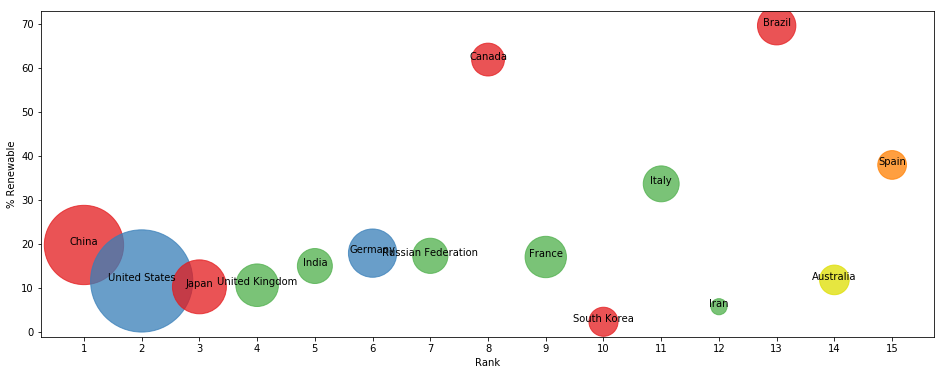

In [89]:
ax = top15.plot(x='Rank', y='% Renewable', kind='scatter', 
                c=['#e41a1c','#377eb8','#e41a1c','#4daf4a','#4daf4a','#377eb8','#4daf4a','#e41a1c',
                    '#4daf4a','#e41a1c','#4daf4a','#4daf4a','#e41a1c','#dede00','#ff7f00'], 
                xticks=range(1,16), s=6*top15['2014']/10**10, alpha=.75, figsize=[16,6]);

for i, txt in enumerate(top15.index):
    ax.annotate(txt, [top15['Rank'][i], top15['% Renewable'][i]], ha='center')

In [90]:
from bokeh.io import output_file, show, output_notebook